In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

# Patient details file yaml/json
import yaml

import warnings
from datetime import datetime

import seaborn as sns
plt.rcParams['lines.linewidth'] = 0.75

import numpy as np
import pandas as pd
def df_repr_latex(self):
    return '\n'.join([
        r'\vspace{5mm}',
        r'{\scriptsize{\centering{%s}}}' % self.to_latex(),
        r'\vspace{5mm}'
    ])
pd.DataFrame._repr_latex_ = df_repr_latex
from pandas.io.formats.style import Styler
Styler._repr_latex_ = lambda s: s.data._repr_latex_()

class HTMLLatex:
    def __init__(self, html, latex):
        self.html = html
        self.latex = latex
    def _repr_html_(self): return self.html
    def _repr_latex_(self): return self.latex
NewPage = HTMLLatex('<hr>', r'\clearpage\newpage')

from IPython.display import display, HTML, Latex

from dcmfetch import fetch_series
from mriqa.reports import (
    ghosting_report, slice_profile_report, piqt_distortion_report,
    uniformity_report, snr_report, snr_report_multi, svs_report, fid_report,
    phase_background_report, fbirn_full_report, mtf_report
)
from mriqa.dcmio import qa_date, scanner_operator, larmor_frequency, tales_reference_power, transmitter_calibration, gradient_sensitivities

from mriqa.phantoms import SIEMENSLONGBOTTLE, PIQTSP
from mriqa.tools import watermark

# Watermark
wm = watermark()
display(pd.DataFrame(
    {'Watermark': list(wm.values())},
    index=wm.keys()
))

Watermark
CalculationTime  2022-03-08T16:40:42+00:00
User                        birchhub/rtrhd
PythonVersion                CPython 3.9.9
Platform          Linux 4.15.0-159-generic
mriqa                               0.2.11
dcmextras                            0.2.6
pydicom                              2.2.2
scipy                                1.7.3
numpy                               1.22.0
skimage                             0.19.1
matplotlib                           3.5.1

# Summary
Tests Performed:

- Slice shape and Profile
- Distortion and Field of View
- Resolution (MTF)
- Ghosting
- Head Coil SNR
- Head Coil Image Uniformity
- Spectroscopy Lineshape
- PC flow bias
- Long Term Stability

----

All of the above are acceptable.

----

### Details of series to analyse.
The Patient ID, Study ID and Series Numbers of the QA scans.

In [2]:
with open('study.yml') as fp:
    study_info = yaml.safe_load(fp)

patid, studyid = study_info['PatID'], study_info.get('StudyID', '1')
tests = study_info['Tests']
for k, test in tests.items():
    if 'PatID' not in test:
        test['PatID'] = patid
    if 'StudyID' not in test:
        test['StudyID'] = studyid

series = tests['SliceProfile_PIQT']['Series']['3mm']

d = fetch_series(patid, studyid, sernos=series)[0]
scanner, date = d.StationName, qa_date(d)
display(
    pd.DataFrame(
        {'Details':[scanner, date, patid, studyid]}, 
        index=['Scanner', 'Date', 'Patient', 'Study']
    )
)

Details
Scanner        CRIC45064
Date            20211111
Patient  AQA20211111CRIC
Study                  1

In [3]:
# Siemens Long Bottle: localizer
info = tests['TuneupParams']
patid, studyid = info['PatID'], info['StudyID']
series = info['Series']
dobj = fetch_series(patid, studyid, sernos=series)[0]

scandate = datetime.strptime(qa_date(dobj), '%Y%m%d').strftime('%B %Y')
operator = scanner_operator(dobj, 'BIRCH')
text = '''
{}
Medical Physics & Bioengineering, UH Bristol
{}
'''.format(operator, scandate)
display(HTMLLatex(
    r'<pre>' + text + r'</pre>',
    r'\vfill' + '\n' + r'\begin{verbatim}' + '\n' + text + '\n' + r'\end{verbatim}' + '\n'
))

In [4]:
NewPage

## Slice Profile

These are the profiles of 3mm and 5mm slices in a conventional spin echo with a T<sub>E</sub> of 30ms using the PIQT slice profile block.

### 3 mm Slice

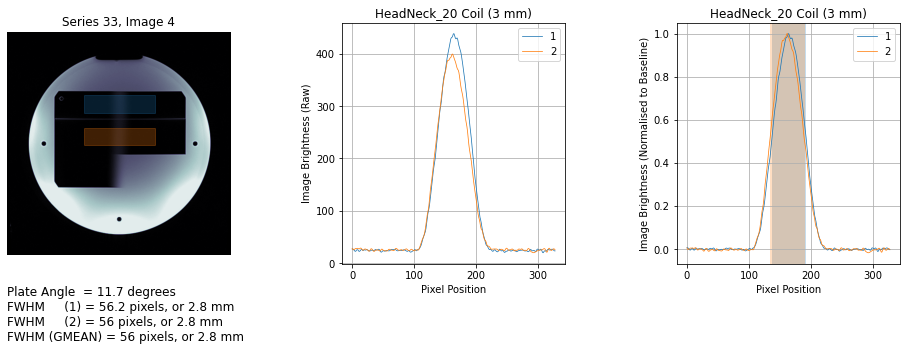

In [5]:
# TO2: Slice 3mm
info = tests['SliceProfile_PIQT']
series, slice_idx = info['Series']['3mm'], info['Slice']['3mm']

# Distortion Corrected, Phase RL, Non-Uniformity Corrected 512*512
dobjs = fetch_series(patid, studyid, sernos=series)
results = slice_profile_report(dobjs[slice_idx], phantom=PIQTSP, flipped_ud=False, flipped_rl=False)

### 5 mm Slice

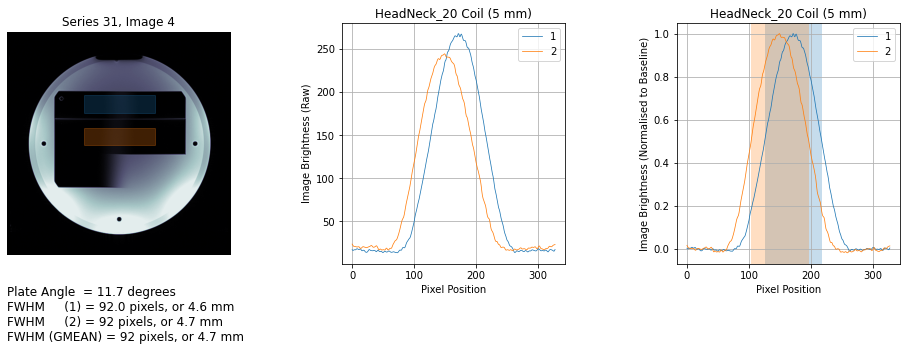

In [6]:
# TO2: Slice 5mm
# Distortion Corrected, Phase RL, Non-Uniformity Corrected 512*512
info = tests['SliceProfile_PIQT']
series, slice_isx = info['Series']['5mm'], info['Slice']['5mm']
dobjs = fetch_series(patid, studyid, sernos=series)
result = slice_profile_report(dobjs[slice_idx], phantom=PIQTSP, flipped_ud=False, flipped_rl=False)
results = results.append(result)

In [7]:
pd.set_option('precision', 1)
results[['FWHMGMeanPixels', 'FWHMGMeanMM']].rename(columns={
    'FWHMGMeanPixels': 'Projected FWHM (pixels)',
    'FWHMGMeanMM': 'True FWHM (mm)'
})

Projected FWHM (pixels)  True FWHM (mm)
SliceThickness                                         
3.0                                56.2             2.8
5.0                                92.4             4.7

These are both rather rounded profiles as seen on other Siemens scanners with this protocol and the profile widths are a little below the nominal values. These, though, are within the AAPM tolerance of 0.5mm.

In [8]:
NewPage

## Image Scaling and Geometric Distortion

The PIQT phantom has a a grid of objects for scale and distortion measurements in plane. The scale reflects the Gradient Sensitivity calibration performed by the manufacturer as part of the system installation. These results are _after_ applying Siemens 2D distortion correction.

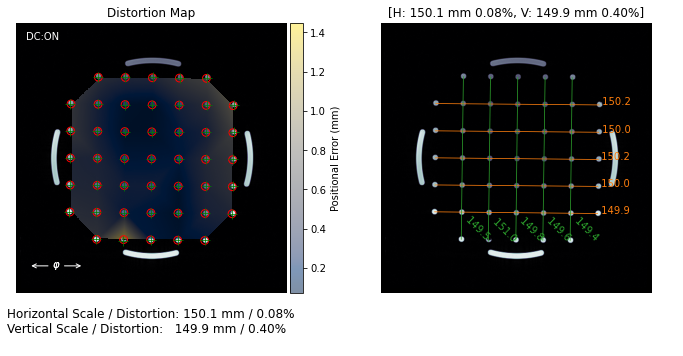

In [9]:
# PIQT: Distortion
info = tests['Distortion_PIQT']
patid, studyid = info['PatID'], info['StudyID']
series, slices = info['Series'], info['Slice']

# SE: Axial, Phase RL, 512 matrix
dobj = fetch_series(patid, studyid, sernos=series['AxialRL_Corrected'])[slices['AxialRL_Corrected']]
results = piqt_distortion_report(dobj)

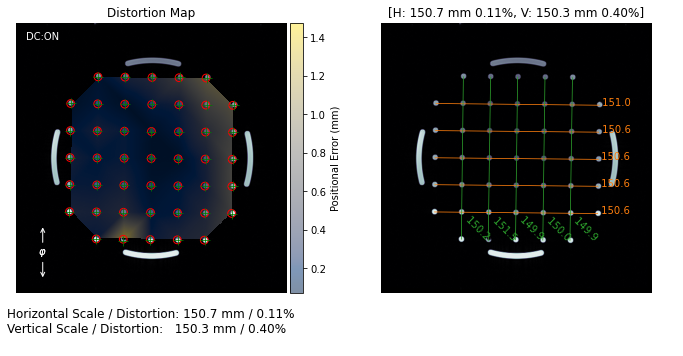

In [10]:
# PIQT: Distortion
# SE: Axial, Phase AP, 512 matrix
dobj = fetch_series(patid, studyid, sernos=series['AxialAP_Corrected'])[slices['AxialAP_Corrected']]
results = results.append(piqt_distortion_report(dobj))

In [11]:
pd.set_option('precision', 3)
results[[
    'Orientation', 'PhaseDirection', 'Sensitivity',
    'HorizontalScale', 'HorizontalDistortion',
    'VerticalScale', 'VerticalDistortion'
]].rename(columns={
    'PhaseDirection': 'Phase Direction',
    'HorizontalScale': 'Horizontal Scale (mm)', 'HorizontalDistortion':'Horizontal Distortion',
    'VerticalScale': 'Vertical Scale (mm)', 'VerticalDistortion': 'Vertical Distortion'  
})

Orientation Phase Direction  Sensitivity  Horizontal Scale (mm)  \
Series                                                                   
33           Axial              RL        0.236                150.052   
35           Axial              AP        0.236                150.700   

        Horizontal Distortion  Vertical Scale (mm)  Vertical Distortion  
Series                                                                   
33                      0.078              149.873                0.397  
35                      0.108              150.295                0.398

The scale in both the RL and AP directions are well within 1% at the bandwidth used (260Hz/pixel).

In [12]:
NewPage

## Resolution

Image resolution is estimated by analysis of the MTF block in the PIQT phantom.

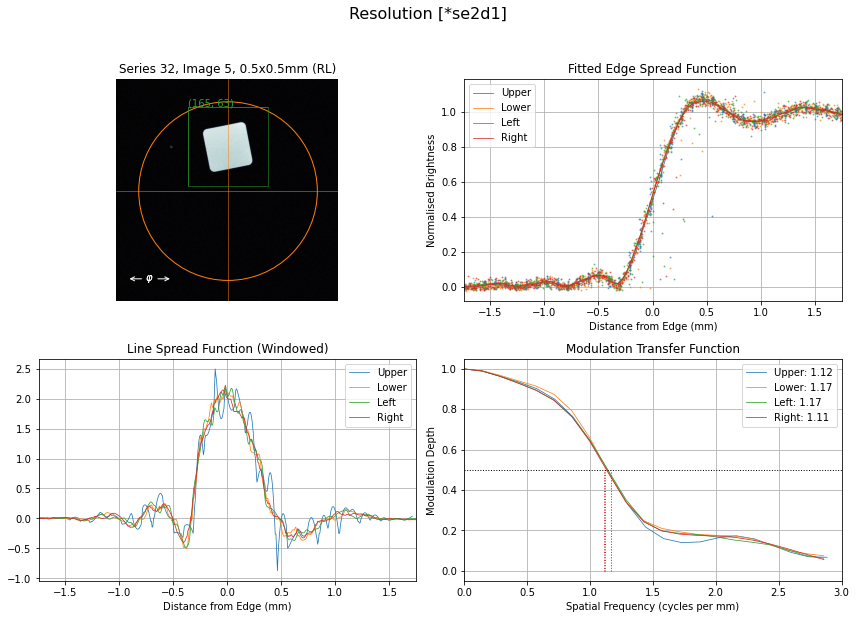

MTF_50
Upper   1.118
Lower   1.166
Left    1.166
Right   1.109

In [13]:
# PIQT: Resoution/MTF
info = tests['Resolution_PIQT']
patid, studyid = info['PatID'], info['StudyID']
series, slices = info['Series'], info['Slice']

# SE: Axial, Phase RL, 512 matrix
dobjs = sorted(fetch_series(patid, studyid, sernos=[series['SE512']]), key=lambda d: int(d.InstanceNumber))
dobj_mtf, dobj_centre = dobjs[slices['MTF']], dobjs[slices['Centre']]

results = mtf_report(dobj_mtf, dobj_centre)
plt.show()
results

The MTF_50 is consistent with an image resolution of 0.5 x 0.5 mm.

In [14]:
NewPage

## Ghosting

Image ghosting is assessed following the approach of [AAPM report 100](https://www.aapm.org/pubs/reports/RPT_100.pdf) for the transverse orientation and four example sequences.

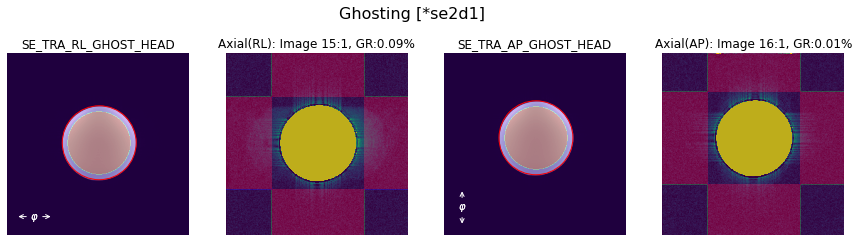

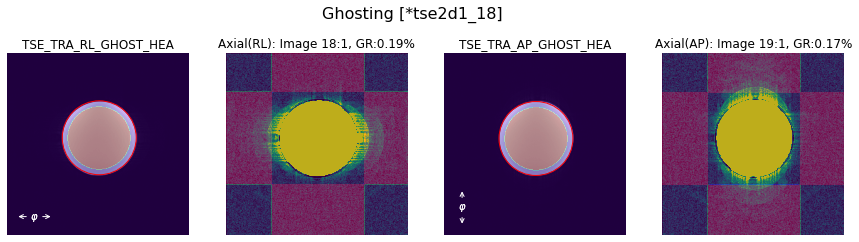

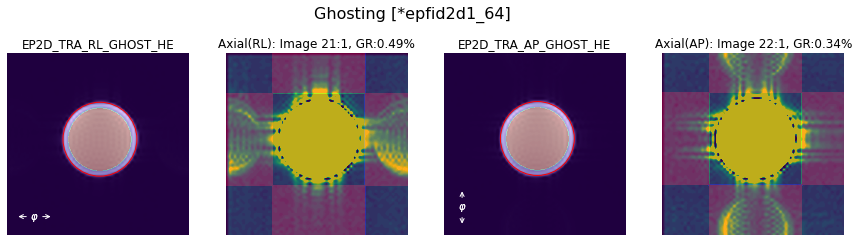

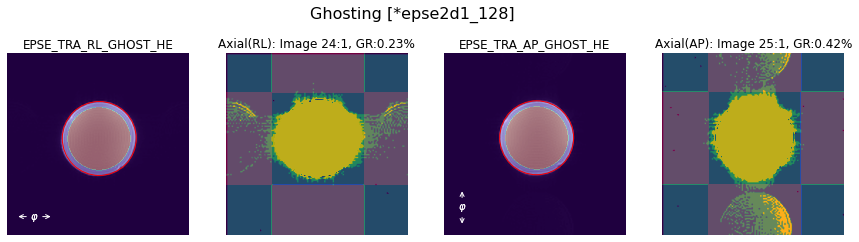

Sequence Orientation Phase Direction  Ghost Ratio (%)
Series                                                           
15            *se2d1       Axial              RL            0.086
16            *se2d1       Axial              AP            0.013
18        *tse2d1_18       Axial              RL            0.187
19        *tse2d1_18       Axial              AP            0.174
21      *epfid2d1_64       Axial              RL            0.485
22      *epfid2d1_64       Axial              AP            0.336
24      *epse2d1_128       Axial              RL            0.227
25      *epse2d1_128       Axial              AP            0.420

In [15]:
# GE10CM: Ghosting
info = tests['Ghosting_GE10']
patid, stuid = info['PatID'], info['StudyID']
series = info['Series']

# SE Axial
dobjs = [fetch_series(patid, stuid, sernos=[serno])[0] for serno in series['SE']]
_, axs = plt.subplots(1, 4, figsize=(15, 4))
results = ghosting_report(dobjs, axes=list(axs.flat))

# TSE18 Axial
dobjs = [fetch_series(patid, stuid, sernos=[serno])[0] for serno in series['TSE']]
_, axs = plt.subplots(1, 4, figsize=(15, 4))
results = results.append(ghosting_report(dobjs, axes=list(axs.flat)))

# EPI64 Axial
dobjs = [fetch_series(patid, stuid, sernos=[serno])[0] for serno in series['EP2D']]
_, axs = plt.subplots(1, 4, figsize=(15, 4))
results = results.append(ghosting_report(dobjs, axes=list(axs.flat)))
plt.show()

# EPISE128 Axial
dobjs = [fetch_series(patid, stuid, sernos=[serno])[0] for serno in series['EPSE']]
_, axs = plt.subplots(1, 4, figsize=(15, 4))
results = results.append(ghosting_report(dobjs, axes=list(axs.flat)))
plt.show()

with pd.option_context('display.precision', 3):
    display(
        results[['Sequence', 'Orientation', 'PhaseDirection', 'GhostRatio']].rename(columns={
            'PhaseDirection': 'Phase Direction', 'GhostRatio': 'Ghost Ratio (%)'
        })
    )

The level of ghosting is under 1% for all sequences measured here including the EPIs. The worst ghosting is seen on the GRE EPI and looks to be predominantly first order.

In [16]:
NewPage

## Receiver Coil Uniformity

We have tested the uniformity of the head coil using a spherical phantom filled with a silicone oil. Results are presented both before and after Siemens `prescan-normalize` intensity correction.

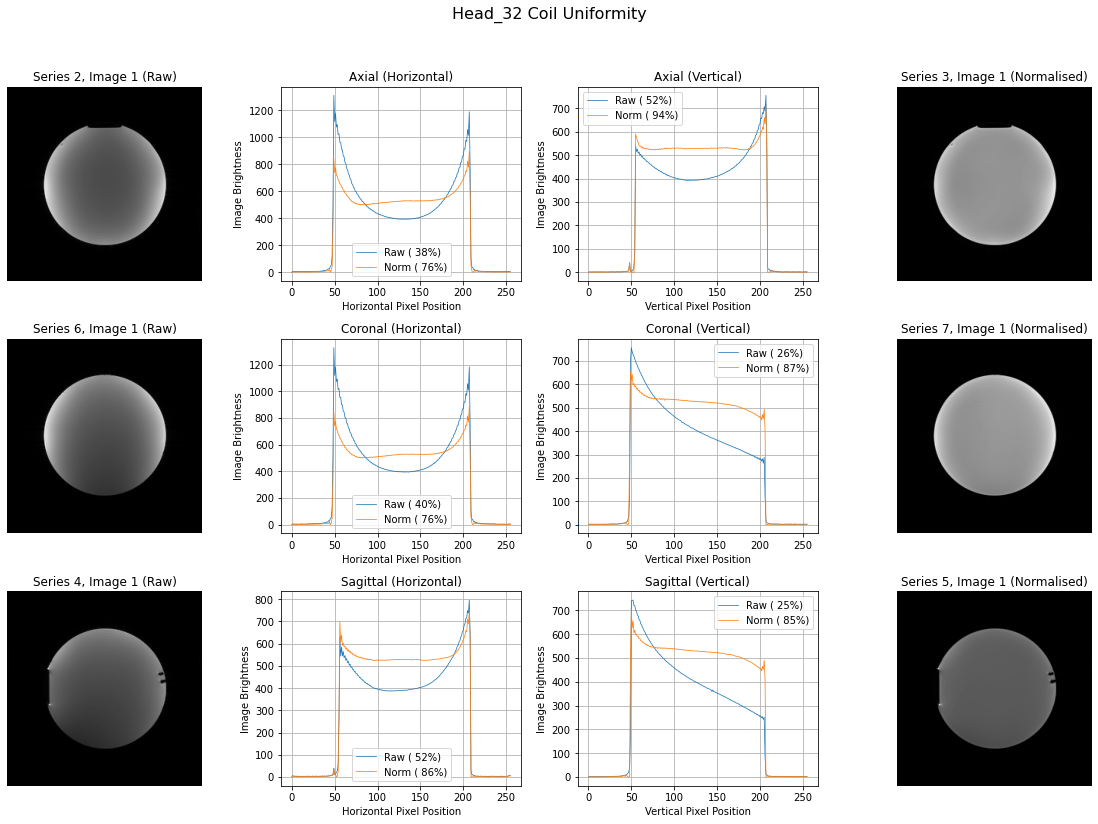

Raw Images


Series No.                         Protocol         Axis  \
Orientation                                                             
Axial                 2  SE_TRA_RL_UNIF_HEAD_OIL20CM_PSN     Axial/RL   
Coronal               6  SE_COR_FH_UNIF_HEAD_OIL20CM_PSN   Coronal/RL   
Sagittal              4  SE_SAG_AP_UNIF_HEAD_OIL20CM_PSN  Sagittal/AP   

              X Uniformity (%)  Y Uniformity (%)  
Orientation                                       
Axial                    37.65             51.95  
Coronal                  40.12             25.79  
Sagittal                 51.95             25.48

Intensity Normalised Images


Series No.                         Protocol         Axis  \
Orientation                                                             
Axial                 3  SE_TRA_RL_UNIF_HEAD_OIL20CM_PSN     Axial/RL   
Coronal               7  SE_COR_FH_UNIF_HEAD_OIL20CM_PSN   Coronal/RL   
Sagittal              5  SE_SAG_AP_UNIF_HEAD_OIL20CM_PSN  Sagittal/AP   

              X Uniformity (%)  Y Uniformity (%)  
Orientation                                       
Axial                    76.40             93.51  
Coronal                  76.40             86.79  
Sagittal                 86.36             84.81

In [17]:
# OILSPHERE: Uniformity
# SE Axial,Coronal,Sagittal; w w/o Intensity Normalization
info = tests['Uniformity_Oil']
patid, stuid = info['PatID'], info['StudyID']
series = info['Series']

raw_tra = fetch_series(patid, stuid, sernos=series['Axial'][0])
psn_tra = fetch_series(patid, stuid, sernos=series['Axial'][1])
raw_sag = fetch_series(patid, stuid, sernos=series['Sagittal'][0])
psn_sag = fetch_series(patid, stuid, sernos=series['Sagittal'][1])
raw_cor = fetch_series(patid, stuid, sernos=series['Coronal'][0])
psn_cor = fetch_series(patid, stuid, sernos=series['Coronal'][1])

if len(raw_tra) > 1:
    results = uniformity_report(
        raw_dobjs=[raw_tra[0], raw_sag[0], raw_cor[0]],
        psn_dobjs=[psn_tra[0], psn_sag[0], psn_cor[0]],
        raw_dobjsb=[raw_tra[1], raw_sag[1], raw_cor[1]],
        psn_dobjsb=[psn_tra[1], psn_sag[1], psn_cor[1]]
    )
else:
    results = uniformity_report(
        raw_dobjs=[raw_tra[0], raw_sag[0], raw_cor[0]],
        psn_dobjs=[psn_tra[0], psn_sag[0], psn_cor[0]],
    )

plt.show()

with pd.option_context('display.precision', 2):
    print('Raw Images')
    display(
        results[['SeriesRaw',  'ProtocolRaw',  'OrientRaw', 'XUniformityRaw', 'YUniformityRaw']].rename(columns={
            'SeriesRaw': 'Series No.', 'ProtocolRaw': 'Protocol', 'OrientRaw': 'Axis',
            'XUniformityRaw': ' X Uniformity (%)', 'YUniformityRaw': 'Y Uniformity (%)'
        })
    )
    print('Intensity Normalised Images')
    display(
        results[['SeriesNorm', 'ProtocolNorm', 'OrientNorm', 'XUniformityNorm', 'YUniformityNorm']].rename(columns={
            'SeriesNorm': 'Series No.', 'ProtocolNorm': 'Protocol', 'OrientNorm': 'Axis',
            'XUniformityNorm': ' X Uniformity (%)', 'YUniformityNorm': 'Y Uniformity (%)'
        })
    )

As expected for a multi-element coil the uncorrected images are significantly non-uniform. However, the Siemens `prescan-normalize` intensity correction is adequate in compensating for this.

In [18]:
NewPage

## Signal to Noise

The Siemens QA involves a comprehensive element by element assessment of the SNR of all the coils. For reference purposes the following is an independent estimate for the head coil using the Siemens long bottle phantom. The SNR is estimated over centred discs with diameters 50% and 75% of the phantom. The signal is taken from a region within the phantom in the mean of two images and the noise is estimated from a background region in their difference image.

### 32 Channel Head Coil

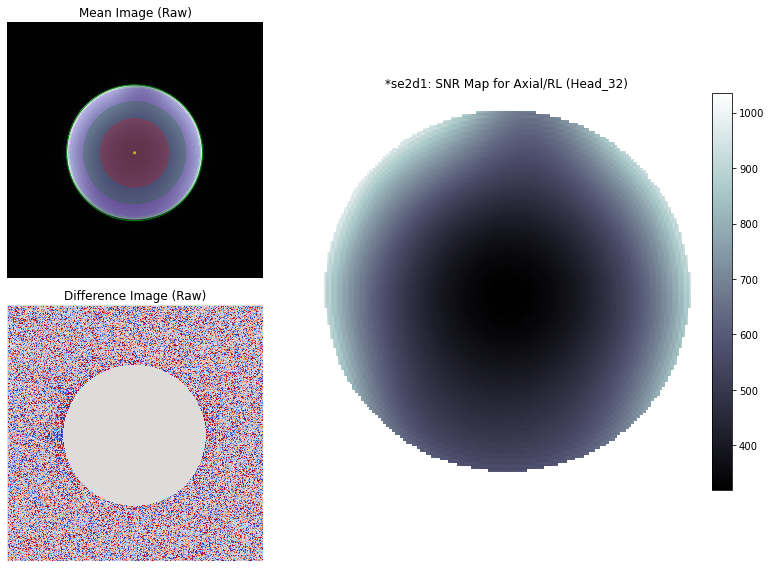

SNR: Raw Images


Head_32
RegionSize         
0.50          393.0
0.75          474.0

In [19]:
# LONGBOTTLE: Signal to Noise
info = tests['QuarterlySNR']
patid, stuid = info['PatID'], info['StudyID']
series = info['Series']

raw_tra = fetch_series(patid, stuid, sernos=series['Signal_Combined'])
if len(raw_tra) > 1:
    results = snr_report(raw_dobjs=[raw_tra[0]], raw_dobjsb=[raw_tra[1]])
else:
    results = snr_report(raw_dobjs=[raw_tra[0]])
plt.show()

print('SNR: Raw Images')
with pd.option_context('display.precision', 2):
    display(np.round(results))

These results are similar to those we have obtained on other 3T Siemens scanners under these conditions.

In [20]:
NewPage

### Single-element Images
This is the SNR calculated from individual element images combined as a sum of squares. This is the methodology used in the quarterly QA.

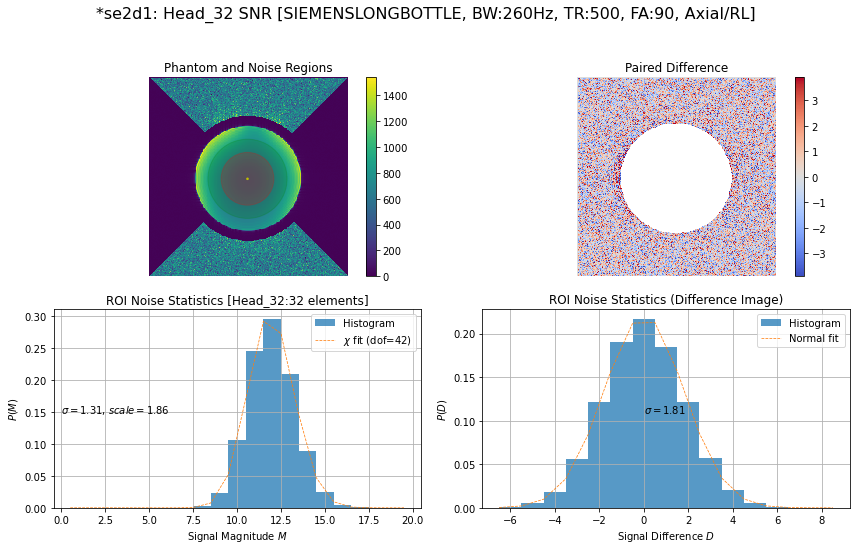

Head_32
0.50   410.16
0.75   495.56

In [21]:
# SNR (uncombined channels)
from mriqa.dcmio import coil_elements
dobjs = sorted(
    fetch_series(patid, stuid, series['Signal']),
    key=lambda x: (int(x.SeriesNumber), int(x.AcquisitionNumber), coil_elements(x)[0])
)
nchannels = len(set(coil_elements(d)[0] for d in dobjs))
dobjsa, dobjsb = dobjs[:nchannels], dobjs[nchannels:]

results = snr_report_multi(dobjsa, dobjsb, phantom=SIEMENSLONGBOTTLE)
plt.show()

with pd.option_context('display.precision', 2):
    display(results)

In [22]:
NewPage

## MR Spectroscopy

### Unsupressed Water FID (no localisation)

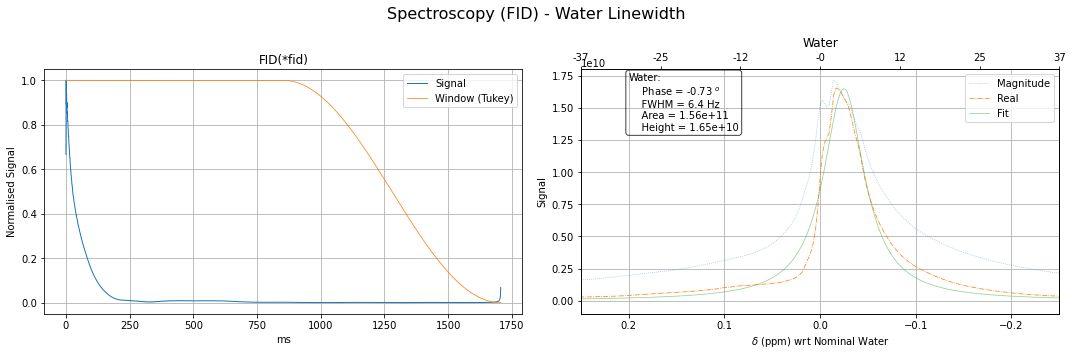

In [23]:
# Siemens MRS Phantom: Water Line width and shape
info = tests['Spectroscopy']
patid, studyid = info['PatID'], info['StudyID']
series = info['Series']

dobj = fetch_series(patid, studyid, sernos=series['FID'])[0]
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    fid_report(dobj)

### Single Voxel Spectroscopy

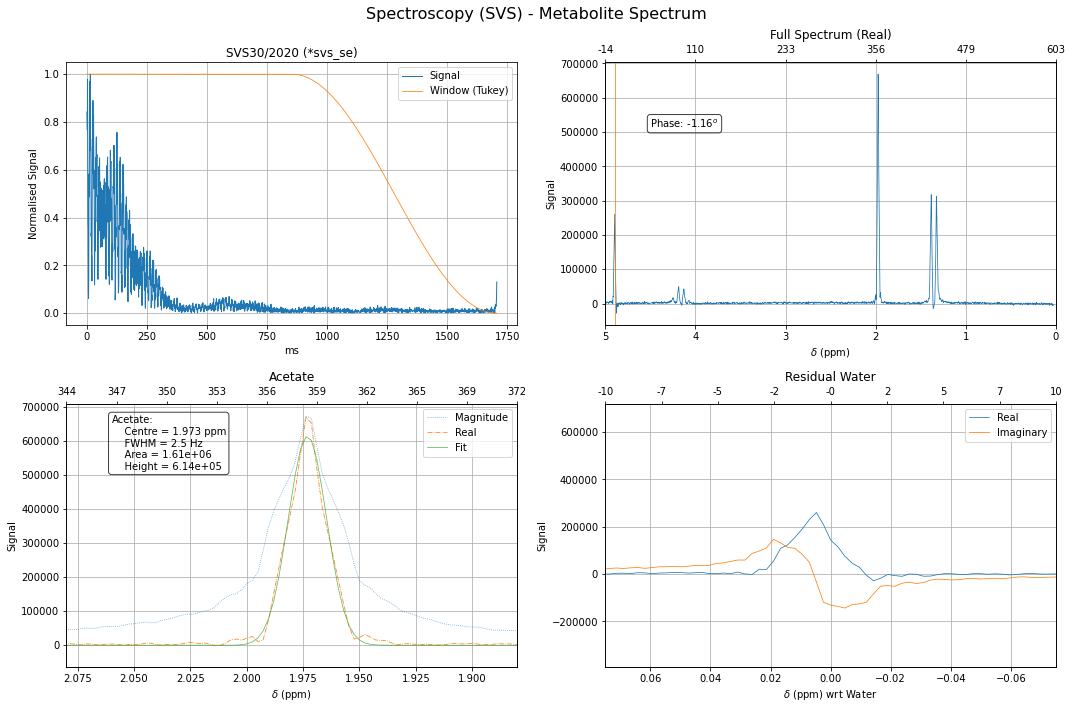

In [24]:
# Siemens MRS Phantom: Acetate Line width and shape
info = tests['Spectroscopy']
patid, studyid = info['PatID'], info['StudyID']
series = info['Series']

dobj = fetch_series(patid, studyid, sernos=series['SVS_SE_30'])[0]
with warnings.catch_warnings():
    warnings.simplefilter('ignore')    
    result = svs_report(dobj)

Species      Height  FWHMHz  LocationPPM     AreaHz
*svs_se  Acetate  613868.738   2.466        1.973  1.611e+06
*svs_st  Acetate  448597.481   2.337        1.973  1.116e+06

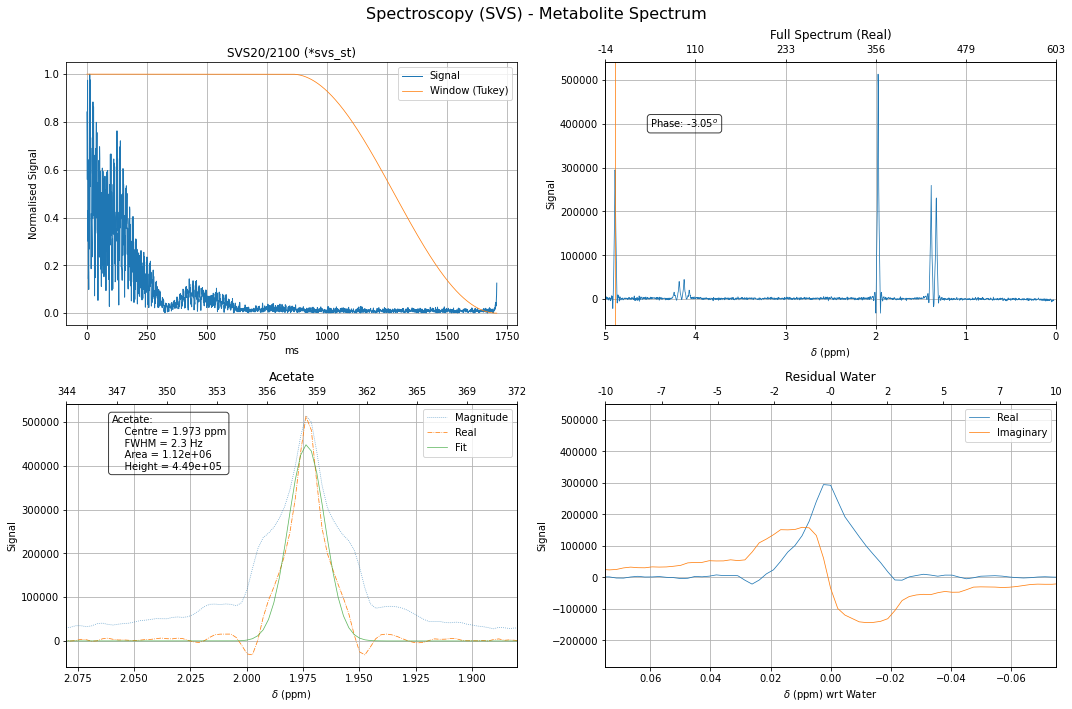

In [25]:
# Siemens MRS Phantom: Acetate Line width and shape
info = tests['Spectroscopy']
patid, studyid = info['PatID'], info['StudyID']
series = info['Series']

dobj = fetch_series(patid, studyid, sernos=series['SVS_ST_20'])[0]
with warnings.catch_warnings():
    warnings.simplefilter('ignore') 
    result = result.append(svs_report(dobj))
result

There is some line shape distortion on the unsupressed water FID, likely due to shim errors acros the phantom but the acetate line in SVS localised spectra is free from significant artefacts and there is no apparent eddy current induced baseline distortion.

In [26]:
NewPage

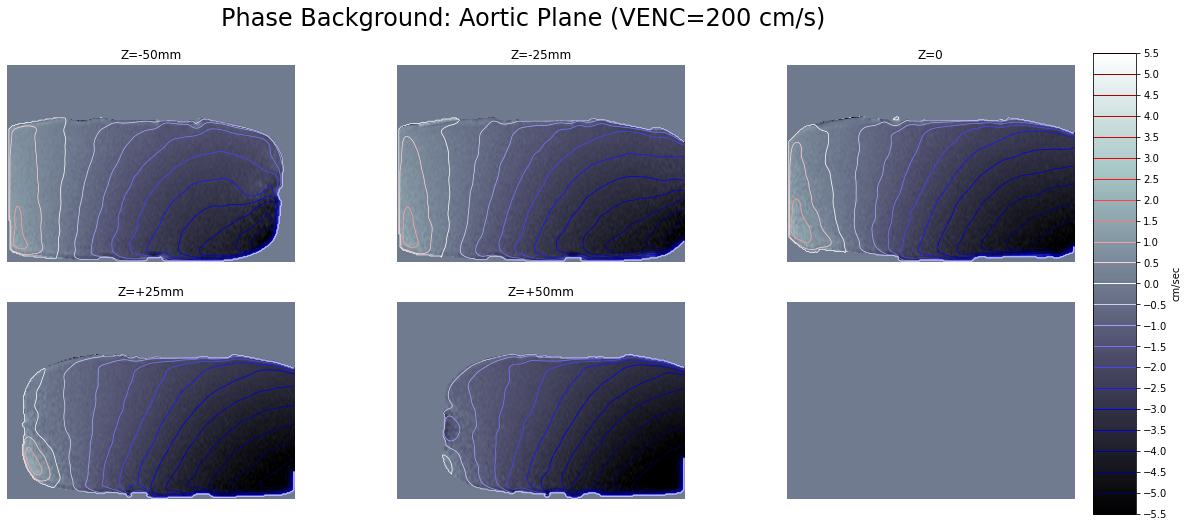

In [27]:
# Gerry Can Phantom: PC flow zero velocity
info = tests['PCFlowBias']
patid, studyid = info['PatID'], info['StudyID']
magnitude_series = info['Series']['AP_Magnitude']
phase_series = info['Series']['AP_Phase']
dobjs_magnitude = fetch_series(patid, studyid, sernos=magnitude_series)
dobjs_phase = fetch_series(patid, studyid, sernos=phase_series)
results = phase_background_report(dobjs_magnitude, dobjs_phase, plane='Aortic', transpose=True)

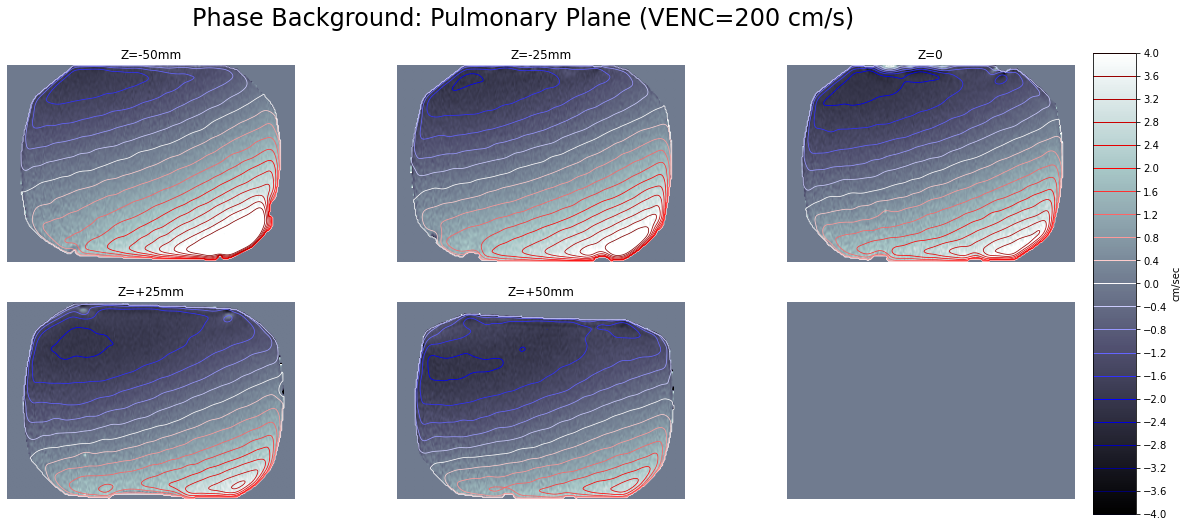

Sequence          Protocol   Venc  MaxPositiveError  \
Plane                                                                 
Aortic     *fl2d1_v200in     AorticPlane Z  200.0             1.226   
Pulmonary  *fl2d1_v200in  PulmonaryPlane Z  200.0             4.524   

           MaxNegativeError  
Plane                        
Aortic               -5.497  
Pulmonary            -2.070

In [28]:
# Gerry Can Phantom: PC flow zero velocity
info = tests['PCFlowBias']
patid, studyid = info['PatID'], info['StudyID']
magnitude_series = info['Series']['PP_Magnitude']
phase_series = info['Series']['PP_Phase']
dobjs_magnitude = fetch_series(patid, studyid, sernos=magnitude_series)
dobjs_phase = fetch_series(patid, studyid, sernos=phase_series)
results = results.append(phase_background_report(dobjs_magnitude, dobjs_phase, plane='Pulmonary'))
plt.show()
results

The velocity offset PC flow measurements in both aortic and pulmonary vessel planes is less than 5% away from the edges of the phantom and slowly varying across the field of view. The results are similar to previous ones from this scanner.

In [29]:
NewPage

## Long Term Stability
We assessed the long term stability of an EPI acquisition over a period of 20 minutes. This was performed on a spherical silicone oil phantom using the bold (mosaic) EPI sequence.

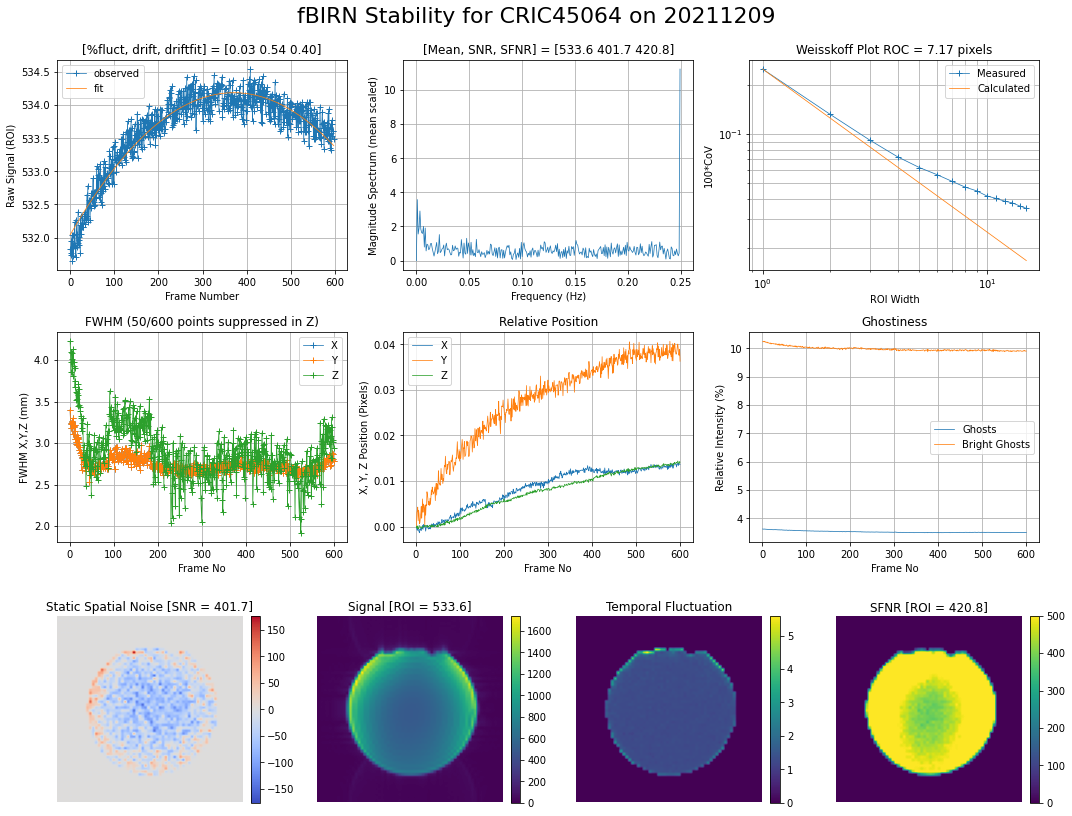

Fluctuations  FittedDrift  Ghosts  BrightGhosts  \
CRIC45064_20211209         0.035        0.402   3.517         9.982   

                    SignalMean      SNR     SFNR  
CRIC45064_20211209     533.639  401.745  420.819

In [30]:
# FBIRN Spherical Phantom: Long Term stability
info = tests['Stability']
patid, studyid = info['PatID'], info['StudyID']
series = info['Series']

dobjs = fetch_series(patid, studyid, sernos=series['Long_20min'])
results = fbirn_full_report(dobjs)
plt.show()
results

The results are broadly similar to previous measurements but there is a (low level) signal fluctuation between odd and even time points. This is apparent in the Fourier spectrum and in the bias visible in the static spatial noise image. This was not present on previous scans but was confirmed at a further visit on 24/02/2022. It is at a very low level and is unlikely to significantly affect fmri studies but would bear further investigation.

In [31]:
NewPage

### Frequency Reference and Transmitter Voltage
These are the reference values reported in the DICOM header of the Localizer scan.

In [32]:
# Localiser on Siemens Long Bottle
info = tests['TuneupParams']
patid, studyid = info['PatID'], info['StudyID']
series = info['Series']
dobj = fetch_series(patid, studyid, sernos=series)[0]

df = pd.DataFrame({
    'ImagingFrequency': [larmor_frequency(dobj)],
    'TransmitterCalibration': [transmitter_calibration(dobj)],
    'TalesReferencePower': [tales_reference_power(dobj)],
    'GradientSensitivityX': [
        float(gradient_sensitivities(dobj)[0]) * 1e6,
    ],
    'GradientSensitivityY': [
        float(gradient_sensitivities(dobj)[1]) * 1e6,
    ],
    'GradientSensitivityZ': [
        float(gradient_sensitivities(dobj)[2]) * 1e6,
    ]
}, index=['Value']).T
df

Value
ImagingFrequency         123.254
TransmitterCalibration   359.344
TalesReferencePower     1883.762
GradientSensitivityX      89.915
GradientSensitivityY      90.037
GradientSensitivityZ      88.350